# Multiple Linear Regression - Predicting US Life Expectancy

Given the sheer size of the features involved and for better interpretation for client, it might be worthy to narrow down the number of variables involved here. Below are some of the ways we can achieve this:

- Baseline Method: Using all available variables [*Note this just creating a baseline model with no feature selection here*]
- Naive Selection: using only features that are highly correlated to 'Life Expectancy' [*we used a 0.65 correlation threshold*]
- Filter Method: dropping features with low variance followed by removing highly correlated features to solve for multicollinearity
- Stepwise Selection: Adding only features with p-values below a set threshold of 0.01
- Recursive Feature Elimination: sklearn's function of greedily choosing 
- L1 Regularisation  (Lasso): utilizing sklearn's GridSearch function to optimize for the best 'alpha' parameter which shrinks non-crucial coefficient values to zero hence allowing for feature selection 

Once we get all the features selected by each method above, we pass those into Statsmodel's OLS function. Subsequently, we will select our most prefferred model by comparing their validation's R2 scores, AIC (model complexity) and also consider the number of features included, which is the primary consideration here. 

Post model selection, we will then check if the chosen model satisfies the assumptions of a regression; no multicollinearity between selected features, homosceasticity and normality of errors. In the end, we shall evaluate the model if it fits the purpose for our final user.

First let's import all the required libraries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings

from functions import *

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.preprocessing import StandardScaler

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

Import the data which was previously cleaned in a seperate notebook.

In [2]:
df_clean = pd.read_csv('data/clean_data.csv', index_col = [0])
print ('Number of rows:', df_clean.shape[0])
print ('Number of columns:', df_clean.shape[1])

Number of rows: 3142
Number of columns: 66


Now, let's drop both of the string columns 'State Abbreviation' and 'Name'. We then split the data into X feature and y target as the 'Life_expectancy'.

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy', 'Premature_age-adjusted_mortality', 'Premature_death', 'Injury_deaths', 'Teen_births']

X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy']

# Train-Validation-Test Split & Feature Scaling

Split into training and testing dataset, setting the test size to 1000 samples and a random state of 1 to ensure reproducibility of data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1000, random_state = 1)

Given one our end goal is to rank features, this is not possible as the features are on different unit scales. To enable comparison, let's standardized our dataset using Sklearn's Standard Scaler which transforms the data into its relevant Z-scores (ie. number of standard deviation away from the mean).

In [5]:
scx = StandardScaler()
scy = StandardScaler()

X_train_scaled = pd.DataFrame(scx.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scx.transform(X_test), columns = X_test.columns)

y_train_scaled = np.concatenate(scy.fit_transform(np.array(y_train).reshape(-1,1)))
y_test_scaled = np.concatenate(scy.transform(np.array(y_test).reshape(-1,1)))

Now we further split our training dataset on train - validation in order to test the performnce on each model that we will look to explore (which will be explored further below)

In [6]:
X_subset_train, X_subset_val, y_subset_train, y_subset_val = train_test_split(X_train_scaled, y_train_scaled, test_size = 0.25, random_state = 1)
len(X_subset_train), len(X_subset_val), len(X_test)

(1606, 536, 1000)

Finally ahead of running all the different methods, let's create a dataframe to store all method outcomes for better readability and comparison at every stage

In [7]:
all_model_summary_df = pd.DataFrame([], 
                                    columns = ['Linear_Regression_Models', 
                                               'Train_R2', 'CV_Avg_R2', 'Val_R2', 
                                               'AIC', 'n_features', '>0.05_pvalues'])


all_model_summary_df['Linear_Regression_Models'] = ['Baseline', 'Naive - Top Correlation',
                                 'Filter', 
                                 'RFE', 'Stepwise',
                                 'Lasso']

all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,NaN,NaN,NaN,NaN,NaN,NaN
1,Naive - Top Correlation,NaN,NaN,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Baseline - All available features

Cool, we now start off by using all 63 z-scaled features to run the OLS model, followed by calculating all of the R2 scores, the AIC, number of features and number of features with p-values of more than 0.05.

In [8]:
linreg_baseline = LinearRegression()
linreg_baseline_mean_score = round(np.mean(cross_val_score(linreg_baseline, X_subset_train, y_subset_train, cv = 5)), 3)

In [9]:
baseline_OLS = OLS(y_subset_train, add_constant(X_subset_train)).fit()

baseline_predictions = baseline_OLS.predict(add_constant(X_subset_val))
baseline_train_r2 = round(baseline_OLS.rsquared, 3)

baseline_errors = y_subset_val - baseline_predictions
baseline_val_r2 = round(r2_score(y_subset_val, baseline_predictions), 3)

print ('Baseline Train R-Squared:', baseline_train_r2)
print ('Baseline CV (5-Fold) Mean R-Squared:', linreg_baseline_mean_score)
print ('Baseline Validation Score R-Squared:', baseline_val_r2)

Baseline Train R-Squared: 0.754
Baseline CV (5-Fold) Mean R-Squared: 0.727
Baseline Validation Score R-Squared: 0.757


Without taking any further assumptions on this method, let's update our initial table.

In [10]:
update_model(all_model_summary_df, 'Baseline', baseline_OLS, [baseline_train_r2, linreg_baseline_mean_score, baseline_val_r2])

In [11]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,NaN,NaN,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Naive Selection - Subset of features with highest correlation to Life Expectancy

Given we've 'blindly' included all features in the baseline model, let's try and narrow these down to only include features which are highly correlated with our target variabe, 'Life Expectancy'. First, we initiated a correlation matrix and set our target correlation threshold to 0.65.

In [12]:
target_correlation_threshold = 0.65

absolute_correlation = abs(X_train.corrwith(y_train))
final = absolute_correlation[absolute_correlation > 0.65]
final

Poor_physical_health_days     0.669422
Adult_smoking                 0.704446
Children_in_poverty           0.655710
Frequent_physical_distress    0.674744
Frequent_mental_distress      0.696789
dtype: float64

Using a 0.65 threshold, we've narrowed down from 64 to 8 features. Using these 8 features, let's create another OLS model and evaluate its performance.

In [13]:
linreg_naive = LinearRegression()
linreg_naive_mean_score = round(np.mean(cross_val_score(linreg_naive, 
                                                        X_train_scaled[final.index], 
                                                        y_train_scaled, cv = 5)), 3)

In [14]:
naive_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[final.index])).fit()

naive_predictions = naive_OLS.predict(add_constant(X_subset_val[final.index]))
naive_train_r2 = round(naive_OLS.rsquared, 3)

naive_errors = y_subset_val - naive_predictions
naive_val_r2 = round(r2_score(y_subset_val, naive_predictions), 3)

print ('Naive Train R-Squared:', naive_train_r2)
print ('Naive CV (5-Fold) Score R-Squared:', linreg_naive_mean_score)
print ('Naive Validation Score R-Squared:', naive_val_r2)

Naive Train R-Squared: 0.579
Naive CV (5-Fold) Score R-Squared: 0.574
Naive Validation Score R-Squared: 0.637


In [15]:
update_model(all_model_summary_df, 'Naive - Top Correlation', naive_OLS, [naive_train_r2, linreg_naive_mean_score, naive_val_r2])

In [16]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,0.579,0.574,0.637,4238,6,1
2,Filter,NaN,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


Just by using the 5 (6 with constant) top correlated features, we get almost similar results to our Baseline model!

## 3. Filter - drop features with no / low variance & high correlation with other features

One of the pitfalls of the above methods is that we might have potentially ignored other useful features that might be of use to our final user. 

Coupled with the above, the previously contemplated model might include various highly correlated features, violating the assumptions of a regression model. As such, let's try out best to find a middle ground by using by:

- dropping features with no or low variance. These features typically do not add much predictive value in a model
- dropping features which are highly correlated

Let's start of by dropping features with no or low variance. We can utilize Sklearn's 'variance_threshold' tool to solve this.

In [17]:
variance_threshold = 0.00

low_var_filter = VarianceThreshold(threshold = variance_threshold).fit(X_train_scaled)

dropped_cols = X_train_scaled.columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(dropped_cols))
print ('Low variance features:', list(dropped_cols))

Number of low variance features: 1
Low variance features: ['Release_Year']


In [18]:
High_Var_Features = X_train_scaled.drop(dropped_cols, axis = 1)

Next, let's further narrow down features by excluding highly correlated features. We have defined this as those with pearson's r of > 0.6.

In [19]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.6

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features
print ('Number of features to drop:', len(correlated_features))
print ('Features to drop: \n', list(correlated_features))

Number of features to drop: 21
Features to drop: 
 ['Frequent_mental_distress', 'Uninsured_adults', 'Children_in_poverty', 'Poor_mental_health_days', 'Frequent_physical_distress', 'Insufficient_sleep', 'Some_college', 'Median_household_income', 'Percentage_of_households_with_overcrowding', 'Adult_smoking', 'Uninsured_children', 'Percentage_of_households_with_high_housing_costs', 'Poor_physical_health_days', 'Diabetes_prevalence', 'Limited_access_to_healthy_foods', 'Children_in_single-parent_households', 'Excessive_drinking', 'Children_eligible_for_free_or_reduced_price_lunch', 'Physical_inactivity', 'Food_insecurity', 'Severe_housing_cost_burden']


In [20]:
High_Var_Features_Low_Corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [21]:
linreg_filter = LinearRegression()
linreg_filter_mean_score = round(np.mean(cross_val_score(linreg_filter, 
                                                        X_train_scaled[High_Var_Features_Low_Corr.columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [22]:
filter_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[High_Var_Features_Low_Corr.columns])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_subset_val[High_Var_Features_Low_Corr.columns]))
filter_train_r2 = round(filter_OLS.rsquared, 3)

filter_errors = y_subset_val - filter_predictions
filter_val_r2 = round(r2_score(y_subset_val, filter_predictions), 3)

In [23]:
print ('Filter Train R-Squared:', filter_train_r2)
print ('Filter CV (5-Fold) Score R-Squared:', linreg_filter_mean_score)
print ('Filter Validation Score R-Squared:', filter_val_r2)

Filter Train R-Squared: 0.705
Filter CV (5-Fold) Score R-Squared: 0.68
Filter Validation Score R-Squared: 0.73


In [24]:
update_model(all_model_summary_df, 'Filter', filter_OLS, [filter_train_r2, linreg_filter_mean_score, filter_val_r2])

In [25]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,0.579,0.574,0.637,4238,6,1
2,Filter,0.705,0.68,0.73,3539,38,17
3,RFE,NaN,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


Looks like the filter method performs on a less satisfactory basis across test accuracy, model complexity and the higher number of features (which still might be overwhelming for our end user!)

## 4. Wrapper - Recursive Feature Elimination

In [26]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=5)
rfecv.fit(X_train_scaled, y_train_scaled)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

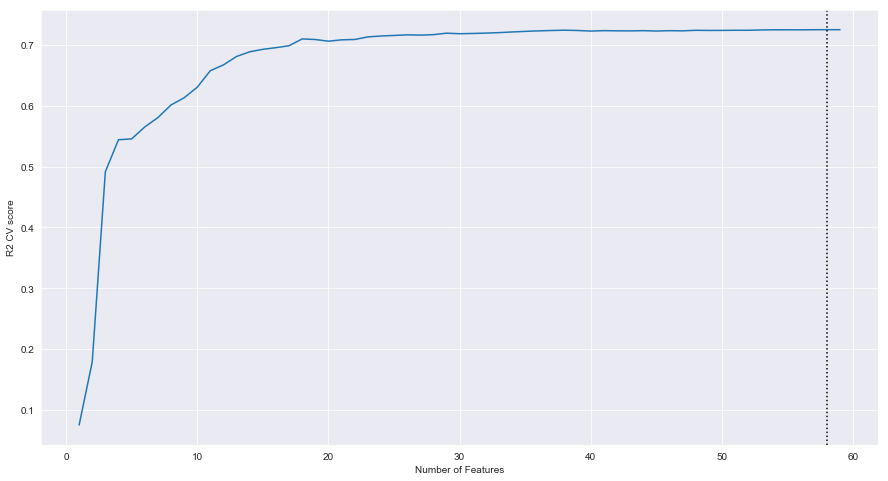

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, linestyle = ':', color = 'black')
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()

In [28]:
RFE_columns = X_train_scaled.columns[rfecv.get_support()]

In [29]:
linreg_RFE = LinearRegression()
linreg_RFE_mean_score = round(np.mean(cross_val_score(linreg_RFE, 
                                                        X_train_scaled[RFE_columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [30]:
RFE_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[RFE_columns])).fit()

RFE_predictions = RFE_OLS.predict(add_constant(X_subset_val[RFE_columns]))
RFE_train_r2 = round(RFE_OLS.rsquared, 3)

RFE_errors = y_subset_val - RFE_predictions
RFE_val_r2 = round(r2_score(y_subset_val, RFE_predictions), 3)

In [31]:
print ('RFE Train R-Squared:', round(RFE_train_r2, 2))
print ('RFE CV (5-Fold) Score R-Squared:', linreg_RFE_mean_score)
print ('RFE Validation Score R-Squared:', RFE_val_r2)

RFE Train R-Squared: 0.76
RFE CV (5-Fold) Score R-Squared: 0.725
RFE Validation Score R-Squared: 0.78


In [32]:
update_model(all_model_summary_df, 'RFE', RFE_OLS, [RFE_train_r2, linreg_RFE_mean_score, RFE_val_r2])

In [33]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,0.579,0.574,0.637,4238,6,1
2,Filter,0.705,0.68,0.73,3539,38,17
3,RFE,0.759,0.725,0.78,3153,59,26
4,Stepwise,NaN,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


This looks slightly better than the filter method however the number of features still remains an issue here.

## 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [34]:
stepwise_columns = stepwise_selection(X_train_scaled, y_train_scaled, threshold_in = 0.01, verbose=True)

Add  Adult_smoking                  with p-value 5.81021e-321
Add  Motor_vehicle_crash_deaths     with p-value 2.11995e-78
Add  Diabetes_prevalence            with p-value 2.0161e-45
Add  Food_insecurity                with p-value 6.9244e-25
Add  Drug_overdose_deaths           with p-value 2.34207e-27
Add  Driving_alone_to_work          with p-value 5.15837e-21
Add  Sexually_transmitted_infections with p-value 1.79051e-20
Add  Median_household_income        with p-value 9.70623e-17
Add  Child_mortality                with p-value 7.24309e-11
Add  Firearm_fatalities             with p-value 1.33178e-08
Add  Air_pollution_-_particulate_matter with p-value 5.03898e-08
Add  %_not_proficient_in_English    with p-value 6.35978e-08
Add  Percentage_of_households_with_overcrowding with p-value 1.79326e-13
Add  %_Rural                        with p-value 1.74222e-09
Drop Food_insecurity                with p-value 0.33006
Add  Mammography_screening          with p-value 4.21286e-11
Add  Prevent

In [35]:
print ('Number of stepwise columns:', len(stepwise_columns))

Number of stepwise columns: 20


In [36]:
linreg_stepwise = LinearRegression()
linreg_stepwise_mean_score = round(np.mean(cross_val_score(linreg_stepwise, 
                                                        X_train_scaled[stepwise_columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [37]:
stepwise_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[stepwise_columns])).fit()

stepwise_predictions = stepwise_OLS.predict(add_constant(X_subset_val[stepwise_columns]))
stepwise_train_r2 = round(stepwise_OLS.rsquared, 3)

stepwise_errors = y_subset_val - stepwise_predictions
stepwise_val_r2 = round(r2_score(y_subset_val, stepwise_predictions), 3)

In [38]:
print ('Stepwise Train R-Squared:', round(stepwise_train_r2, 2))
print ('Stepwise CV (5-Fold) Score R-Squared:', linreg_RFE_mean_score)
print ('Stepwise Validation Score R-Squared:', stepwise_val_r2)

Stepwise Train R-Squared: 0.74
Stepwise CV (5-Fold) Score R-Squared: 0.725
Stepwise Validation Score R-Squared: 0.769


In [39]:
update_model(all_model_summary_df, 'Stepwise', stepwise_OLS, [stepwise_train_r2, linreg_stepwise_mean_score, stepwise_val_r2])

In [40]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,0.579,0.574,0.637,4238,6,1
2,Filter,0.705,0.68,0.73,3539,38,17
3,RFE,0.759,0.725,0.78,3153,59,26
4,Stepwise,0.739,0.727,0.769,3247,21,1
5,Lasso,NaN,NaN,NaN,NaN,NaN,NaN


Now, this looks better than before with a less complex model, fairly reasonable test R2 and a manageable amount of features.

## 6. Lasso

First we set the all the hyperparameters we are interested in tuning, primarily the 'penalizing' parameters (alpha). The GridSearch function will be able to obtain the best parameters for us by evaluating them using R2 score.

In [41]:
model = Lasso()
lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}

grid_obj = GridSearchCV(estimator = model, 
                        param_grid = lasso_params, 
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train_scaled, y_train_scaled)
grid_obj.best_params_

{'alpha': 0.05}

Looks like the best alpha level is 0.05.

In [42]:
final_lasso = grid_obj.best_estimator_.fit(X_train_scaled, y_train_scaled)
lasso_coef = pd.Series(final_lasso.coef_, index = X_train_scaled.columns)
lasso_coef = lasso_coef[lasso_coef != 0]

print ('Number of non-0 coef:', len(lasso_coef))
print ('Selected lasso coef:\n', lasso_coef)

Number of non-0 coef: 24
Selected lasso coef:
 Poor_mental_health_days                             -0.002135
Adult_smoking                                       -0.192318
Adult_obesity                                       -0.008558
Physical_inactivity                                 -0.088565
Sexually_transmitted_infections                     -0.081741
Preventable_hospital_stays                          -0.030938
Mammography_screening                                0.018110
Children_in_poverty                                 -0.058808
Children_in_single-parent_households                -0.008361
Violent_crime                                       -0.001851
Air_pollution_-_particulate_matter                  -0.028213
Driving_alone_to_work                               -0.093056
Child_mortality                                     -0.065782
Frequent_mental_distress                            -0.085174
Diabetes_prevalence                                 -0.019556
Food_insecurity        

In [43]:
linreg_lasso = LinearRegression()
linreg_lasso_mean_score = round(np.mean(cross_val_score(linreg_lasso, 
                                                        X_train_scaled[lasso_coef.index], 
                                                        y_train_scaled, cv = 5)), 3)

In [44]:
Lasso_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[lasso_coef.index])).fit()

Lasso_predictions = Lasso_OLS.predict(add_constant(X_subset_val[lasso_coef.index]))
Lasso_train_r2 = round(Lasso_OLS.rsquared, 3)

Lasso_errors = y_subset_val - Lasso_predictions
Lasso_val_r2 = round(r2_score(y_subset_val, Lasso_predictions), 3)

In [45]:
print ('Lasso Train R-Squared:', round(Lasso_train_r2, 2))
print ('Lasso CV (5-Fold) Score R-Squared:', linreg_lasso_mean_score)
print ('Lasso Validation Score R-Squared:', Lasso_val_r2)

Lasso Train R-Squared: 0.73
Lasso CV (5-Fold) Score R-Squared: 0.716
Lasso Validation Score R-Squared: 0.754


In [46]:
update_model(all_model_summary_df, 'Lasso', Lasso_OLS, [Lasso_train_r2, linreg_lasso_mean_score, Lasso_val_r2])

In [47]:
all_model_summary_df

,Linear_Regression_Models,Train_R2,CV_Avg_R2,Val_R2,AIC,n_features,>0.05_pvalues
0,Baseline,0.754,0.727,0.757,2352,60,32
1,Naive - Top Correlation,0.579,0.574,0.637,4238,6,1
2,Filter,0.705,0.68,0.73,3539,38,17
3,RFE,0.759,0.725,0.78,3153,59,26
4,Stepwise,0.739,0.727,0.769,3247,21,1
5,Lasso,0.728,0.716,0.754,3342,25,8


# Model Evaluation & Selection - Stepwise Selection

Okay, looking purely by R2 scores, model complexity and optimum number of features, we have decided to go for the Stepwise model. However we will still need to check if the model fits the regression assumptions. First let check for multicollinearity using the VIF metric. 

In [48]:
stepwise_baseline = X_train_scaled[stepwise_columns]
stepwise_baseline['Intercept'] = 1

stepwise_VIF = pd.DataFrame()
stepwise_VIF["variables"] = stepwise_baseline.columns
stepwise_VIF["VIF"] = [variance_inflation_factor(stepwise_baseline.values, i) for i in range(stepwise_baseline.shape[1])]

stepwise_VIF

,variables,VIF
0,Adult_smoking,2.983273
1,Motor_vehicle_crash_deaths,1.946758
2,Drug_overdose_deaths,1.157203
3,Driving_alone_to_work,1.815198
4,Sexually_transmitted_infections,1.811231
5,Median_household_income,2.937060
6,Child_mortality,1.591696
7,Firearm_fatalities,1.460519
8,Air_pollution_-_particulate_matter,1.685923
9,%_not_proficient_in_English,2.127171


Cool, since no features are more than 10, multicollinearity is not a big concern here. Next we check for homoscedasticity by plotting the residuals.

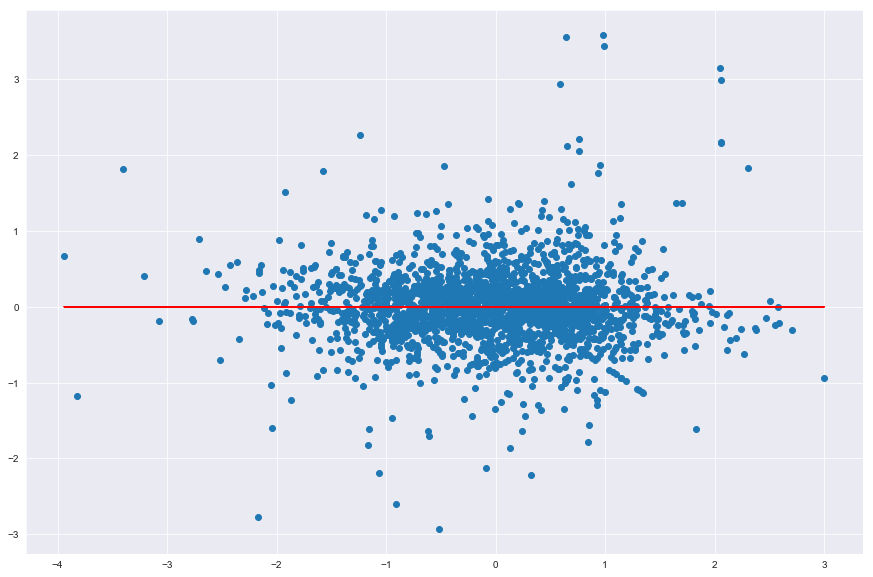

In [49]:
stepwise_updated = X_train_scaled[stepwise_columns]
stepwise_updated.insert(0, 'const', 1)

stepwise_OLS.predict(stepwise_updated)
len(stepwise_OLS.resid)

plt.figure(figsize = (15,10))
plt.scatter(stepwise_OLS.predict(stepwise_updated), stepwise_OLS.resid)
plt.plot(stepwise_OLS.predict(stepwise_updated), [0 for i in range(len(X_train_scaled))], color = 'r')
plt.show()

This looks fine with no concerning trends. No we look at the normality of the errors using the QQ plot and distribution of errors

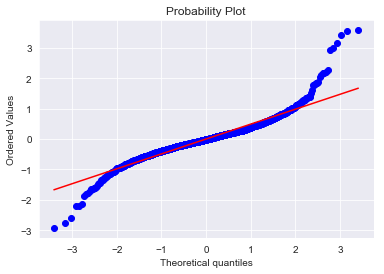

In [50]:
residuals = stepwise_OLS.resid
fig = stats.probplot(residuals, dist="norm", plot=pylab)

Whilst majority of the points still lie on the line between -2 and 2, visually this is still not ideal which is likely caused by outliers. Let's investigate the outliers for the target and see if there are any significant changes between quantiles/

In [51]:
updated_scaled = X_train_scaled
updated_scaled['Life_expectancy'] = y_train_scaled

list_range = np.linspace(0, 0.1, 11)
for i in list_range:
    print (round(i, 5), round(updated_scaled.Life_expectancy.quantile(i),2))

0.0 -5.0
0.01 -2.37
0.02 -2.08
0.03 -1.86
0.04 -1.71
0.05 -1.58
0.06 -1.49
0.07 -1.43
0.08 -1.36
0.09 -1.3
0.1 -1.23


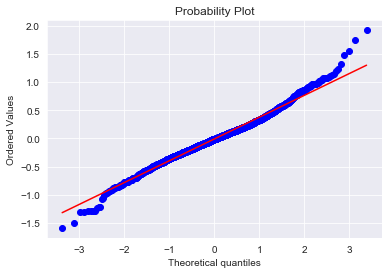

In [52]:
to_use_scaled = updated_scaled[(updated_scaled.Life_expectancy < 1.5) & (updated_scaled.Life_expectancy > -1.5)]
to_use_x_train_scaled = to_use_scaled.drop(['Life_expectancy'], axis = 1)
to_use_y_train_scaled = to_use_scaled.Life_expectancy

stepwise_OLS_scaled_outliers = OLS(to_use_y_train_scaled, to_use_x_train_scaled[stepwise_columns]).fit()
residuals_outlier = stepwise_OLS_scaled_outliers.resid
stats.probplot(residuals_outlier, dist="norm", plot=pylab)
pylab.show()

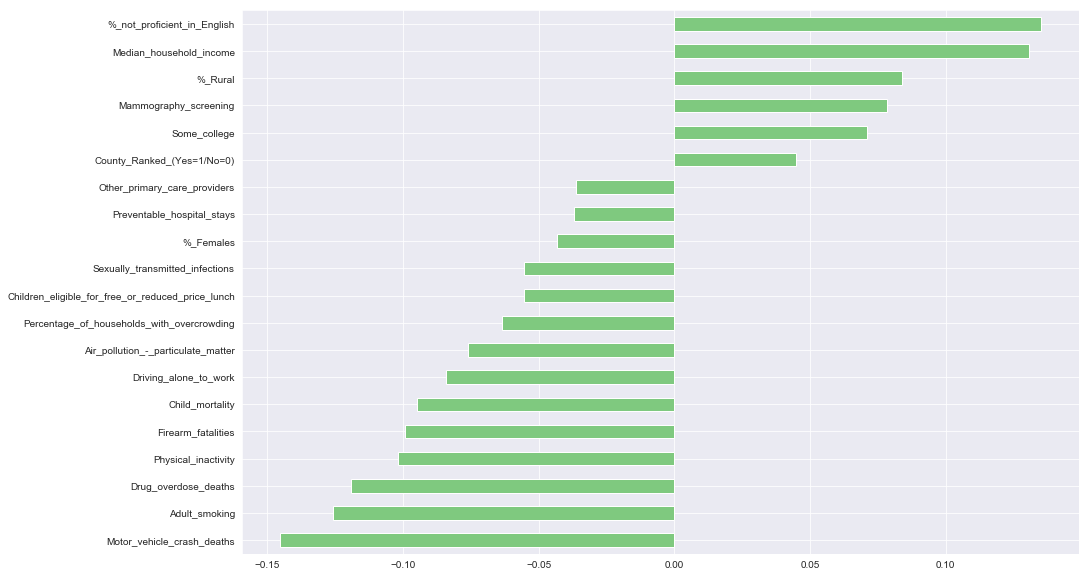

In [53]:
stepwise_OLS_scaled_outliers.params.sort_values().plot(kind = 'barh', figsize = (15,10), cmap = 'Accent')
plt.show()

# Testing on Test Dataset

In [54]:
stepwise_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[stepwise_columns])).fit()

stepwise_test_predictions = stepwise_OLS.predict(add_constant(X_test_scaled[stepwise_columns]))
print ('Test R2 of:', round(r2_score(y_test_scaled, stepwise_test_predictions), 2) * 100, '%')

Test R2 of: 68.0 %


# Conclusion and future work

To conclude, it is important to emphasize that whilst we have chosen the model above, there are many other methods out there which may result in a better model. That said, the above model should at least provide our end user with the crucial indicators for estimating life expectancy.

For future work and to further improve the R2 score, we will look to:
- investigate performance of forward / backward selection, Ridge regression, interactions and polynomials
- user other models apart from OLS, ie RF, CART, etc